<a href="https://colab.research.google.com/github/yalipan666/GPT-2-for-Psycholinguistic-Applications/blob/master/%5BNSAS2024%5D_Cognitive_Models_of_Behavior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cognitive Models of Behavior: Classical and Deep Learning Approaches

**Tutorial for NSAS Summer School 2024**

By Kevin Miller, Maria Eckstein, and Kim Stachenfeld

# Introduction and Getting Started


## Getting Set Up

**1) Create your own copy of this notebook:** File > Save a copy in Drive.

If you need to find the original notebook again you can find it at [this link](https://colab.research.google.com/drive/1bt_ELyVppre7_Sz2jz8fy2UwDlEIm_8d)

**2) Connect to a free cloud-based backend:** Connect (top right) > Connect to a hosted runtime.

Select "TPUv2-8" if available, or "T4 GPU" otherwise. If neither of those are available, ask Kevin for help.


## Colab Hints

**Navigating colab notebooks:** Colab notebooks consist of "cells", which are organized into hierarchical sections with section titles. (The title of this section is "Introduction and Getting Started"). To view the overall structure of the notebook, click the button at the top left with an icon of a bulletpoint list (three rows each with a dot next to a line). Sections can be collapsed, in which case most of the cells will be hidden. To expand a section and see all the cells, click the sideways arrow (>) next to the section title.

**To execute code:**
Colab consists of "text" cells (like this one) which contain text or pictures, and "code" cells, which contain Python code that you can execute. To execute the code in a cell, you can execute invidiually. To execute a "cell", you'll press Shift-Enter.

**Need help?** To view information about a function or class, type `?` before the name of the function or class (For example, `?print` or `?str` will cause information about the print function or the string datatype to pop up on the right.)

# Resources

**Code:** This tutorial does not require you to write any code (though if you are comfortable writing code, feed free to modify things and explore!). It draws on code from two repositories. The first is associated with our "disentangled RNNs" paper and can be found at [github.com/google-deepmind/disentangled_rnns](https://github.com/google-deepmind/disentangled_rnns). The second is custom for this tutorial, and can be found at [github.com/kevin-j-miller/Cog_Modeling_Classic_Deep_Tutorial](https://github.com/kevin-j-miller/Cog_Modeling_Classic_Deep_Tutorial). Feel free to peruse this code as you work your way through the tutorial.



## Introduction & Overview

In this Colab, you will learn how to implement and work with some of today's models.

* **Part 1: Understanding Synthetic Data**

* **Interlude: Selecting a Dataset**. We'll pick a dataset to use moving forward. Your first time through, you'll pick a synthetic dataset made using a Q-Learning model like the one you thought about in Part 1. Once you reach the end of the tutorial, you'll return here and select other datasets to try.

* **Part 2: Fitting a Classic Reinforcement Learning (RL) Model.** We will learn *how to fit a computational model* (e.g., what is a negative log likelihood?). And we will see *what we can learn from an RL model* (e.g., interpreting values and learning rates). We will also see what we *can't* learn from this model (think interpretability versus predictive power).

* **Part 3: Fitting a recurrent neural network to the same dataset.** We will learn how to set up and train a neural network on a dataset (spoiler: it's not that hard!). We will see how it solves some of the problems we encountered when working with the classic RL model (think predictive power). And we will also see that we now encounter new problems (think interpretability).

* **Part 4: Fitting interpretability-encouraging RNNs.** There are *many* ways to solve this conundrum. We will talk about two specific ones:
  * *Disentangled RNNs*, which produce interpretable models of behavior by forcing a neural network to disentangle its representation.
  * *Hybrid RNNs*, which test specific asssumptions of RL in a fully data-driven way, using neural networks.

* **Part 5: Repeat Parts 2-4 with a "Mystery Agent" and see if we can uncover its mechanisms.** In Part 1, we are using fitting a two-parameter Q-learning model to behavior generated by a matching two-parameter Q-learning agent -- no surprise if we can fit that! Now we will explore using a "mystery agent" whose mechanism is unknown and is not an exact match for the RL model.

* **Part 6: Repeat Parts 2-4 with a laboratory dataset** from rats performing a two-armed bandit task. We will see how different model classes shed light on the learning behavior of real rats.

***Let's get started!***

# Imports

Go ahead and run the two cells below to install and load the required packages.

In [ ]:
#@title Clone the github repositories
# Remove existing copies, if they exist
!rm -rf Cog_Modeling_Classic_Deep_Tutorial

# Clone the repository
!git clone https://github.com/kevin-j-miller/Cog_Modeling_Classic_Deep_Tutorial
!pip install -r Cog_Modeling_Classic_Deep_Tutorial/requirements.txt


Cloning into 'Cog_Modeling_Classic_Deep_Tutorial'...
remote: Enumerating objects: 951, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 951 (delta 159), reused 99 (delta 98), pack-reused 755 (from 1)
Receiving objects: 100% (951/951), 5.00 MiB | 21.35 MiB/s, done.
Resolving deltas: 100% (581/581), done.


In [ ]:
#@title Imports + defaults settings.
%load_ext autoreload
%autoreload 2

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optax
import os
import warnings

warnings.filterwarnings("ignore")

#from disentangled_rnns.library import disrnn
#from disentangled_rnns.library import get_datasets
#from disentangled_rnns.library import two_armed_bandits

from Cog_Modeling_Classic_Deep_Tutorial.CogModelingRNNsTutorial import bandits
from Cog_Modeling_Classic_Deep_Tutorial.CogModelingRNNsTutorial import rat_data
from Cog_Modeling_Classic_Deep_Tutorial.CogModelingRNNsTutorial import disrnn
from Cog_Modeling_Classic_Deep_Tutorial.CogModelingRNNsTutorial import hybrnn
from Cog_Modeling_Classic_Deep_Tutorial.CogModelingRNNsTutorial import plotting
from Cog_Modeling_Classic_Deep_Tutorial.CogModelingRNNsTutorial import rnn_utils



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Section 1: Generating Synthetic Datasets

In this section, you will get experience defining a simple reinforcement learning (RL) agent which interacts with a simple "two-armed bandit" environment. The exercises in this section are intended to provide an intuition for the structure of the environment and how the agent works.

First, we want to get an intuition for the types of agents and environments that we will be working with. This builds on code (in the `bandits.py` file on
[github](https://github.com/kstach01/CogModelingRNNsTutorial), in case you are curious -- you should not need to access the code directly to do these exercises). The code in `bandits.py` implements RL agents (called `AgentQ`) and 2-armed bandit task environment (called `EnvironmentBanditsDrift`).

Below we will define an instance of agent and environment, respectively.

Execute the cell below to do all of this.

<a name="rl-in-a-nutshell"></a>
## RL in a nutshell

The environment in this task is a 2-armed drifting bandit, meaning that there are two available actions that each elicit stochastic rewards, and the probability of the reward drifts gradually over time.

An RL agent learns "Q-values" for each action (aka the expected reward of each action) in order to decide what choices to make. When the agent receives a reward for an action it chose, it will increment the Q-value of this action; when it does not receive a reward for its action, it will decrease the corresponding action value.

Repeating this process over and over, the agent's Q-values will get closer and closer to the actual reward probabilities. This means that the agent will be able to choose actions well, and therefore maximize rewards.


We'll see what this looks like for a single trial. First, we'll define an agent in the cell below. Then, we'll see how Q-values are modified after a single trial containing one choice and one reward outcome.

**Deep Dive: Q-values**

Remember that in RL, we always calculate reward prediction errors $\delta$:

$$\delta_t = r_t - Q_t(a_t)$$

In other words, we see how much reward $r$ we obtained on trial $t$ to get $r_t$. Then we check what the value $Q$ is of the action $a$ we chose on trial $t$ to get $Q_t(a_t)$. This entity $Q_t(a_t)$ is our "reward prediction".

Now, all that's left is to look at the difference between $Q_t(a_t)$ (our reward prediction) and the actual reward $r_t$, to obtain our "reward prediction error" $\delta_t$.

With the reward prediction error $\delta$, we can update our value $Q_t(a_t)$ to obtain $Q_{t+1}(a_t)$:

$$Q_{t+1}(a_t) = Q_t(a_t) + \alpha * \delta_t$$

For the update, we *could* simply add the reward prediction error $\delta_t$ to our old value estimate $Q_t$, to immediately arrive at $r_t$, the true outcome. However, we don't really want to move *all the way* from the old value $V_t$ to the actual outcome $r_t$. We only want to move *a little bit*, in order to keep around some of the things we have already learned in the past.

This is the reason why we first multiply $\delta_t$ by $\alpha$, the *learning rate*, before we add it to $Q_t(a_t)$. (The learning rate $\alpha$ is a number between 0 and 1 that "scales" the reward prediction error. For example, if $\alpha=0.25$, we move a quarter of the way from $Q_t$ to $r_t$.)

In [ ]:
#@title Define an agent and an environment
gen_alpha = 0.25  #@param
gen_beta = 5
n_actions = 2

environment = bandits.EnvironmentBanditsDrift(sigma=0.1, n_actions=n_actions)
agent = bandits.AgentQ(alpha=gen_alpha, beta=gen_beta, n_actions=environment.n_actions)

# For later: if you would like to check out a different environment, uncomment the lines below.
# environment = bandits.EnvironmentBanditsFlips(
#     block_flip_prob=0.02, reward_prob_high=0.8, reward_prob_low=0.2)

# For later: if you would like to check out a different agent, uncomment the lines below.
# agent = bandits.MysteryAgentQ(alpha=gen_alpha, beta=gen_beta, n_actions=environment.n_actions)

In [ ]:
#@title Agent behavior: **One trial.**
agent.new_sess()
print("Agent's initial Q-values:", agent.q)
# print("Environment's Reward Probabilities:", environment.reward_probs)
choice = agent.get_choice()
print("Agent's choice", choice)
reward = environment.step(choice)
print("Reward provided by the environment: ", reward)
agent.update(choice=choice, reward=reward)
print("Agent's new Q-values:", agent.q)

Agent's initial Q-values: [0.5 0.5]
Agent's choice 1
Reward provided by the environment:  True
Agent's new Q-values: [0.5   0.625]


**Question:** How did the Q-values change as a result of this outcome? What happened to the chosen action? What happened to the unchosen action?

**Exercise:** Execute the cell a few times to see what happens when the agent makes different choices and when it observes different outcomes.


Now, let's see how the agent performs on the task, doing 200 trials in a row on the environment we specified. Execute the cells below to run the agent through the loop.

**Questions:**
* What do the orange and blue line represent?
* What do the vertical green and red ticks represent?
* What is the relationship between the orange/blue and red/green lines


In [ ]:
#@title Agent behavior: **One session**

n_trials = 200  #@param
choices = np.zeros(n_trials)
rewards = np.zeros(n_trials)
qs = np.zeros((n_trials, n_actions))
reward_probs = np.zeros((n_trials, n_actions))

# For each trial: Step the agent, step the environment, record everything
for trial_i in np.arange(n_trials):
  # Record environment reward probs and agent Qs
  reward_probs[trial_i, :] = environment.reward_probs
  qs[trial_i, :] = agent.q
  # First, agent makes a choice
  choice = agent.get_choice()
  # Then, environment computes a reward
  reward = environment.step(choice)
  # Finally, agent learns
  agent.update(choice, reward)
  # Log choice and reward
  choices[trial_i] = choice
  rewards[trial_i] = reward

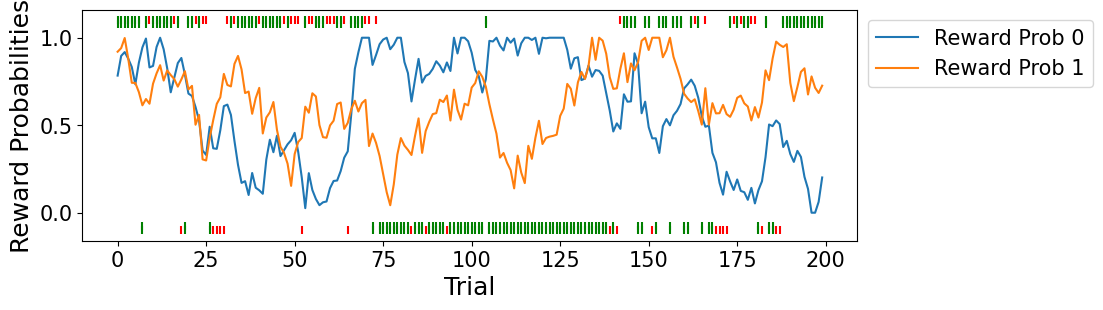

In [ ]:
#@title Plot task structure and agent behavior.
bandits.plot_session(
    choices=choices, rewards=rewards, timeseries=reward_probs,
    timeseries_name='Reward Probabilities',
    labels=[f'Reward Prob {a}' for a in range(n_actions)])


Let's understand how the agent made the choices it made - let's look under the hood. Execute the cell below and answer the following

**Questions:**
* What do the orange and blue line represent? (Spoiler: It's different from before)
* What happens to the orange line when there's a green tick on the top of the figure? What happens when there's a red tick on the top? What happens to the orange line when there are ticks on the bottom side?
* How do you explain the movements of the lines? (Hint: This is RL in action! Look back at [RL in a nutshell](#rl-in-a-nutshell))
* How are Q-values and actions related? In other words, how do the orange and blue lines in this figure compare to the orange and blue lines above?

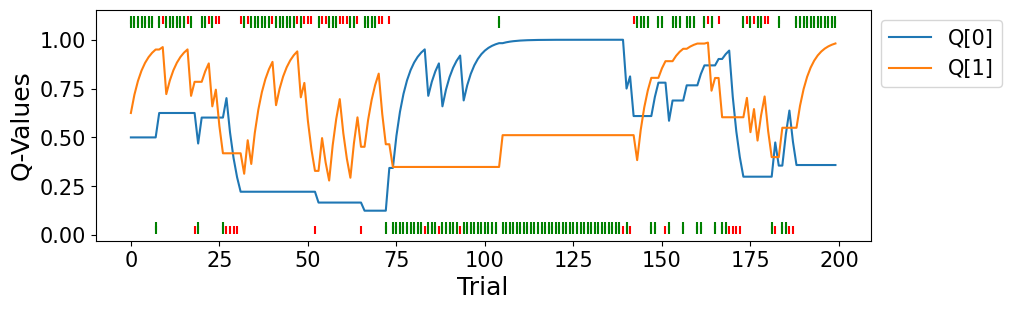

In [ ]:
#@title Plot agent Q-values
bandits.plot_session(
    choices=choices,
    rewards=rewards,
    timeseries=qs,
    timeseries_name='Q-Values',
    labels=[f'Q[{a}]' for a in range(n_actions)])

Now that we know what Q-values are, how a Q-learning agent works, and how it behaves, let's run a whole bunch of them. (This might take a few seconds.)

In [ ]:
#@title Generate synthetic data: **Whole dataset**
n_trials_per_session = 200
n_sessions = 100
dataset_train_to_view, experiment_list_to_view = bandits.create_dataset(
    agent=agent, environment=environment,
    n_trials_per_session=n_trials_per_session, n_sessions=n_sessions)

# To sample the next element in a dataset.
x, y = next(dataset_train_to_view)
print(f'x.shape = {x.shape} \ny.shape = {y.shape}')

x.shape = (200, 100, 2) 
y.shape = (200, 100, 1)


## Diagnostic plots to characterize behavior.
In order to understand the behavior of the agent in a richer way, we can generate some plots describing aspects of its behavior.

Run the cell below to see if the agent's actions are temporally autocorrelated; that is, what fraction of the time the agents choice now are the same as its choice n steps ago.

**Exercise:** what other diagnostics might you like to see? Feel free to make some of your own plots!

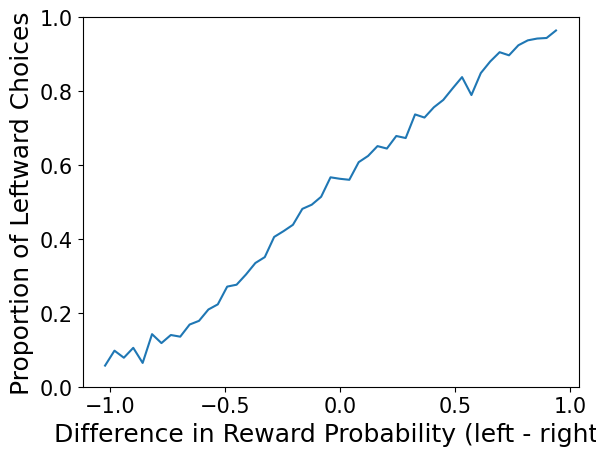

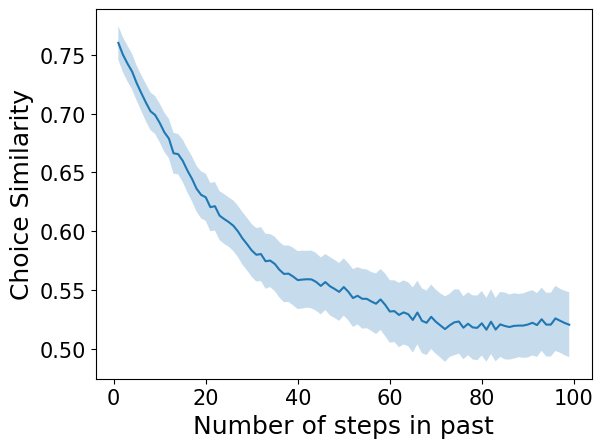

In [ ]:
#Run some diagnostics to characterize the dataset
bandits.show_valuemetric(experiment_list_to_view)
plt.figure()
plotting.plot_action_similarity_to_history(experiment_list_to_view, n_steps_back=100)

**Exercise:** Experiment with different values of alpha and beta.

Go back to [the cell where we defined the agent](#define-agent-and-environment) and change the values of the `alpha` (note: `alpha` must be in the [0, 1] range) and `beta` parameter, then run all the cells until here. What changes in the behavior of the agent when you change `alpha`? What changes in the Q-values?

<a name="select-dataset"></a>
# Interlude: Select a Dataset

Now that we have an understanding of how our RL agent works, we will learn how to fit a cognitive model. In the following cell, select `dataset_type = Synthetic Dataset: Q-Learning` from the dropdown menu on the right. This generate a synthetic dataset similar to the one above, where a Q-learning agent is performing a drifting 2-armed bandit task. Select your preferred learning rate parameter `alpha` (e.g., 0.25), and inverse temperature `beta` (e.g., 5) parameters. Then run the cell to create the dataset.

In later exercises, we will substitute in different datasets by selecting different values for `dataset_type` from the dropdown menu below:
* `Mystery Agent` Synthetic dataset from a "mystery agent" that we have defined, for which the cognitive model does not exactly match the agent
* `Rat Datasets` Real data from real rats performing the same similar task. Data from [Miller et al., 2021](https://www.biorxiv.org/content/10.1101/461129v3).

In [ ]:
#@title Select dataset type.
#@markdown ## Select dataset type:

dataset_type = 'Synthetic Dataset: Q-Learning'  #@param ['Synthetic Dataset: Q-Learning', 'Synthetic Dataset: Mystery Agent', 'Rat Dataset']
is_synthetic = dataset_type.startswith('Synthetic')


#@markdown ###**Parameters for Synthetic Datasets**:
if is_synthetic:
  #@markdown Agent Parameters:
  gen_alpha = .25 #@param
  gen_beta = 5 #@param
  #@markdown Environment Parameters:
  n_trials_per_session = 200  #@param
  n_sessions = 100  #@param
  sigma = .1  #@param
  environment = bandits.EnvironmentBanditsDrift(sigma=sigma)

  # Set up agent.
  agent = {
      'Synthetic Dataset: Q-Learning': bandits.AgentVanillaQ(gen_alpha, gen_beta),
      'Synthetic Dataset: Mystery Agent': bandits.MysteryAgentQ(gen_alpha, gen_beta, mystery_param=-2),
      'Synthetic Dataset: Mystery Agent Two': bandits.ExtraMysteryAgentQ(gen_alpha, gen_beta, mystery_param=0.2),
      }[dataset_type]

  dataset_train, experiment_list_train = bandits.create_dataset(
      agent=agent,
      environment=environment,
      n_trials_per_session=n_trials_per_session,
      n_sessions=n_sessions)

  dataset_test, experiment_list_test = bandits.create_dataset(
      agent=agent,
      environment=environment,
      n_trials_per_session=n_trials_per_session,
      n_sessions=n_sessions)

#@markdown ###**Parameters for Rat Datasets**.

elif dataset_type == 'Rat Dataset':
  rat_number = 1 #@param [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

  if not 'rat_datasets' in locals():
    # This takes a few seconds, so if it's been done already don't bother doing it again
    rat_datasets, rat_experiment_lists = rat_data.get_rat_bandit_datasets()

  dataset = rat_datasets[rat_number-1]
  xs, ys = next(dataset)
  dataset_train = rnn_utils.DatasetRNN(xs[:,0::2,:], ys[:,0::2,:])
  dataset_test = rnn_utils.DatasetRNN(xs[:,1::2,:], ys[:,1::2,:])

  experiment_list = rat_experiment_lists[rat_number-1]

  experiment_list_test = experiment_list[0::2]
  experiment_list_train = experiment_list[1::2]

  gen_alpha = np.nan
  gen_beta = np.nan

else:
  raise NotImplementedError(
      (f'dataset_type {dataset_type} not implemented. '
       'Please select from drop-down list.'))



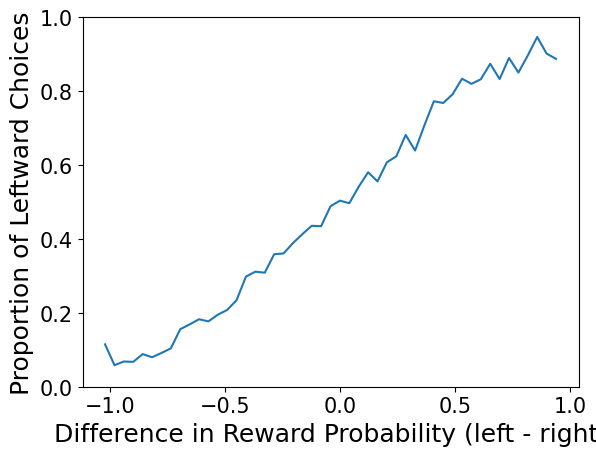

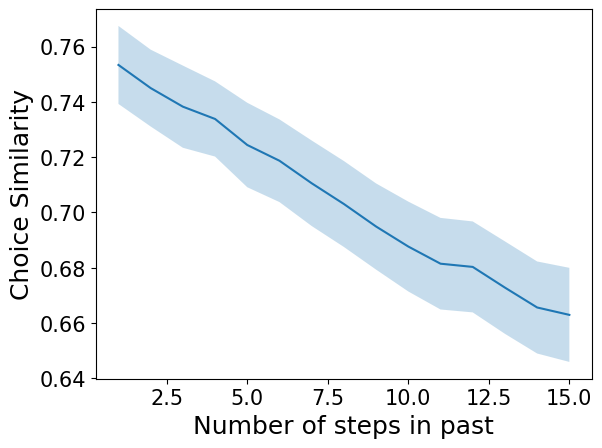

In [ ]:
#@title Run some diagnostics to characterize the dataset
bandits.show_valuemetric(experiment_list_train)
plt.figure()
plotting.plot_action_similarity_to_history(experiment_list_train, n_steps_back=16)


<a name="fit-classic-cognitive-model"></a>
# Section 2: Fit a Classic RL Model

## Fitting the Q-Learning Model to Behavior

To see if subjects use RL, we "fit" the model to human behavior. This means that we adjust the model until it produces behavior that corresponds to the dataset as closely as possible. In this case, the adjustments consist of increasing or decreasing the values of the *free parameters* of the model, learning rate $\alpha$ and inverse decision temperature $\beta$.

How do we know if we need to change the values of $\alpha$ and $\beta$? By checking how close the behavior of the model is to the behavior in our dataset! The closer the model behavior matches human behavior, the better the model "fits" the human dataset, and the less we have to change the parameters. On the other hand, the more different the model behavior is from human behavior, the more we have to still wiggle on $\alpha$ and $\beta$ to get it to match more closely.

We want the best possible fit, so we are looking for the values of $\alpha$ and $\beta$ that maximize the similarity between human and model behavior. To do this, we will *maximizes the probability* that the RL agent chooses the same actions that humans have chosen.

**Put differentls, our goal is to find the values of our model parameters ($\alpha$ and $\beta$) that maximize the likelihood of the observed behavior under the model.**

To do this, we will:
* Write a function that calculates the negative log likelihood (NLL)
* Set up an optimizer that will minimize the NLL
* The smallest NLL corresponds to the best parameters! The model is fitted.

The cell below provides a function that calculates the log likelihood for us. It takes a dataset (`dataset`, e.g., our syntheticly created behavior), a model (`model_fun`, e.g., our Q-learning agent), and model parameters (`params`, e.g., a learning rate `alpha` and an inverse decision temperature `beta`) as inputs.
It returns the normalized likelihood of the dataset under the model and the parameters as an output.

The likelihood of our dataset under the model is simply the probability each choice we see in the dataset would have occurred in the model:
$$p(dataset) = \prod_{s=0}^{100} \prod_{t=0}^{150} p(a_{st})$$
This is the probability of each action at each trial $t$, for each subject $s$, which our model (aka RL agent) produces.

Because this is hard to calculate (numbers will get very small with so many multiplications), we take a trick: We take the log and add instead:
$$p(dataset) = \prod_{s=0}^{100} \prod_{t=0}^{150}p(a_{st}) = \sum_{s=0}^{100} \sum_{t=0}^{150} log(p(a_{st}))$$

And because we don't want the number of trials (150) and subjects (100) to influence our results, we often normalize the log-likelihood:
$$p(dataset) \propto \sum_{s=0}^{n_s} \sum_{t=0}^{n_t} log(p(a_{st})) \ / \ n_s \ / \ n_t$$

In [ ]:
#@title Compute log-likelihood
def compute_log_likelihood(dataset, model_fun, params):

  xs, actual_choices = next(dataset)
  n_trials_per_session, n_sessions = actual_choices.shape[:2]
  model_outputs, model_states = rnn_utils.eval_model(model_fun, params, xs)

  predicted_log_choice_probabilities = np.array(jax.nn.log_softmax(model_outputs[:, :, :2]))

  log_likelihood = 0
  n = 0  # Total number of trials across sessions.
  for sess_i in range(n_sessions):
    for trial_i in range(n_trials_per_session):
      actual_choice = int(actual_choices[trial_i, sess_i])
      if actual_choice >= 0:  # values < 0 are invalid trials which we ignore.
        log_likelihood += predicted_log_choice_probabilities[trial_i, sess_i, actual_choice]
        n += 1

  normalized_likelihood = np.exp(log_likelihood / n)

  print(f'Normalized Likelihood: {100 * normalized_likelihood:.1f}%')

  return normalized_likelihood

Let's see if this all makes sense. Answer the following questions:

* Which values of `alpha` and `beta` should give us the **highest** likelihood for the current dataset? Why is that?  
* Which values should give us very **low** likelihoods?

Now let's see if we were right. Use the cell below to calculate the likelihoods for some different values of `alpha` and `beta`. Type the values into the interface on the right, and execute the cell to calculate the likelihood. Try a few different combinations to see if your intuition was right!

In [ ]:
#@title Calculate the log likelihoods for example parameters
test_alpha = 0.25 #@param
test_beta = 5 #@param

def inverse_sigmoid(x):
  return np.log(x/(1-x))

print('Calculating the log likelihood for alpha = {} and beta = {}.'.format(test_alpha, test_beta))
params = {'hk_agent_q': {'alpha_unsigmoid': inverse_sigmoid(jnp.array([test_alpha])), 'beta': jnp.array([test_beta])}}
_ = compute_log_likelihood(dataset_train, bandits.HkAgentQ, params)

Calculating the log likelihood for alpha = 0.25 and beta = 5.
Normalized Likelihood: 67.2%



If we were to calculate the LL for each combination of $\alpha \in [0, 1]$ and $\beta \in [0, 30]$, this is what we would get for data generated with `gen_alpha=0.75` and `gen_beta=5`. (The red cross marks the smallest NLL, aka best parameter combination):

<center><img src="https://github.com/trendinafrica/TReND-CaMinA/blob/main/notebooks/Ghana23/23-Friday/NllGrid.png?raw=1" width=700></center>

We now have everything in place to fit our model! We have a function that calculates the LL for a model (e.g., Q-learning) and some parameters (e.g., `alpha` and `beta`), on any dataset. All that's left is find the largest possible LL, and we'll have the optimal parameters! (To do this, we usually find the *smallest* possible *negative* LL or NLL. But the logic is the same.)

Congrats on making it until here---this is model fitting in a nutshell!

The next cell does just that: It takes an agent (our Q-learnner) and a dataset (the synthetic one we made above), and finds the parameters with the best LL.

In [ ]:
#@title Fit parameters
rl_params, _ = rnn_utils.fit_model(
    model_fun=bandits.HkAgentQ,
    dataset=dataset_train,
    loss_fun='categorical',
    optimizer=optax.adam(1e-1),
    convergence_thresh=1e-5,
    n_steps_per_call=100,
    n_steps_max=1000)

Step 100 of 100; Loss: 7.9506e+03. (Time: 0.9s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 3e-05s.
Step 100 of 100; Loss: 7.9506e+03. (Time: 0.8s)
Model Converged! Time elapsed = 3e-05s.


While the cell is running, answer the following questions:

* Which parameters do you expect the function to return? I.e., what will the value be of `alpha`? And will the value be of `beta`? Why?
* Would the result be different for a different dataset? Why?

Now let's see! Execute the cell below to see what parameters we have fitted.

In [ ]:
fit_alpha = jax.nn.sigmoid(rl_params['hk_agent_q']['alpha_unsigmoid'][0])
fit_beta = rl_params['hk_agent_q']['beta'][0]

print('Generative beta was: ', gen_beta)
print('Recovered beta was: ', fit_beta)
print('Generative alpha was: ', gen_alpha)
print('Recovered alpha was: ', fit_alpha)

Generative beta was:  5
Recovered beta was:  5.111452
Generative alpha was:  0.25
Recovered alpha was:  0.24630076


**Questions:**
* How does this model do in terms of interpretability? (A good way to think about his might be to think about the variables in the model: `alpha`, `beta`, Q-values. What does it mean that the model is build on these variables? How could we use them in a cognitive neurscience study?)
* How does this model do in terms of predictive power? (You can make a guess here - keep the question in mind until we have also fitted the neural network model in the next section.)

## Quantitative Model Fit

Oftentimes, we want to know the "quality of fit" of a model. This is the case when we fit several models (as we will do shortly), and want to know which one captures the dataset best. One way you might think to do this would be to simply look at the likelihood that we computed when we fit the model. An issue with this approach is "overfitting", where parameters of the model are sensitive not only to the true generalizable structure in the dataset, but also to ideosyncratic or noisy aspects of the dataset that we would not expect to find in a new dataset from the same source. This is especially an issue when working with very powerful models like neural networks.

A simple way of dealing with it is to divide the dataset into separate parts, and use one ("training" dataset) to fit parameters for the model and another ("testing" or "evaluation" dataset) to compute a likelihood score. A model which overfits is expected to earn a higher likelihood score than it "should" on the training set (because it successfully capturing noise) and a lower likelihood score on the testing set.

Sometimes in cognitive modeling, researchers will compute measures such as AIC or DIC. These are approximations to the expected predictive performance of a model that do not rely on splitting the dataset. They are difficult to use with neural networks, since they require an estimate of the number of "effective free parameters" of a model. This is difficult to reliably estimate even for classic cognitive models, and we do not know of a way to reliably do it for neural networks. Other times, researchers will compute a measure known as BIC or the Bayes Factor. This is not an estimate of the model's predictive performance, but purports to estimate instead how strongly we should believe that the dataset was actually generated by our model. When dealing with laboratory datasets, we should never believe this (the dataset was generated by a brain, not a model).


In [ ]:
# Report quality of fit to held-out dataset
print('Normalized Likelihoods for Q-Learning Model')
print('Training Dataset')
training_likelihood = compute_log_likelihood(dataset_train, bandits.HkAgentQ, rl_params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_test, bandits.HkAgentQ, rl_params)

Normalized Likelihoods for Q-Learning Model
Training Dataset
Normalized Likelihood: 67.2%
Held-Out Dataset
Normalized Likelihood: 67.1%


**Questions:**
* What do you observe? Are the likelihoods the same or different? What does that mean?

## Does behavior from the fit model resemble the original data?

The likelihood score that we computed above is useful for comparing models, but is hard to interpet in an absolute sense. (If our best model earns 68%, is that a good score?)

If we want to know whether our model is good as a *generative* model, there is no subsitute for generating some synthetic data and comparing it to the real thing!

The next few cells will generate a synthetic dataset from the fit model, then create diagnostic plots comparing it side-by-side with the real datasets.  If you coded up any of your own visualizations in Part 0, feel free to try them here!



In [ ]:
#@title Synthesize a dataset using the fitted agent
rl_agent = bandits.AgentVanillaQ(alpha=fit_alpha, beta=fit_beta)
_, experiment_list_rl = bandits.create_dataset(rl_agent, environment, n_trials_per_session, n_sessions)

Total Reward Rate is: 60.290%
Total Reward Rate is: 58.400%
Total Reward Rate is: 60.335%


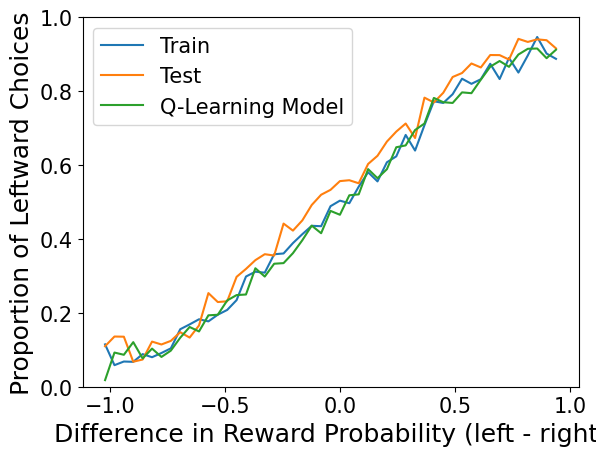

In [ ]:
#@title Plot behavior diagnostics for each model.
bandits.show_valuemetric(experiment_list_train, label='Train')
bandits.show_total_reward_rate(experiment_list_train)

bandits.show_valuemetric(experiment_list_test, label='Test')
bandits.show_total_reward_rate(experiment_list_test)

bandits.show_valuemetric(experiment_list_rl, label='Q-Learning Model')
bandits.show_total_reward_rate(experiment_list_rl)
plt.legend()

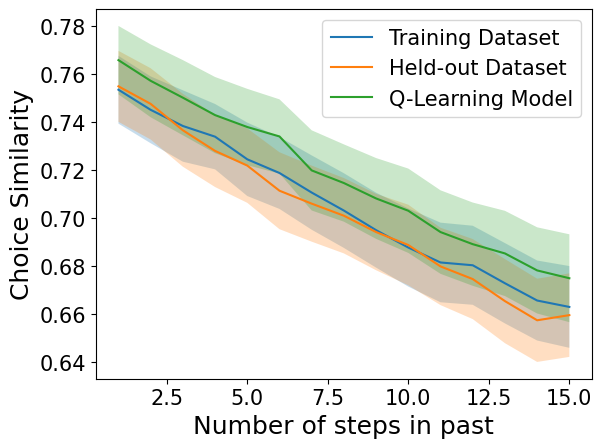

In [ ]:
plotting.plot_action_similarity_to_history(
    experiment_list_train,
    experiment_list_test,
    experiment_list_rl,
    n_steps_back=16,
    labels=['Training Dataset', 'Held-out Dataset', 'Q-Learning Model'])

**Questions:**
* How do the models compare visually?
* Do the different diagnostics tell us different things?

## Interpreting the VanillaQ Model


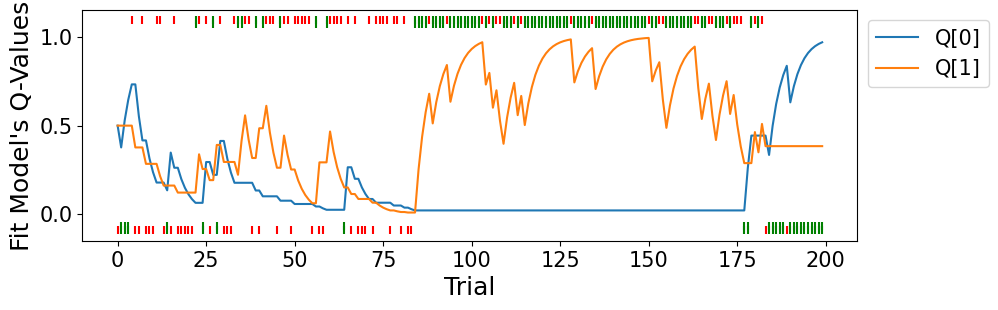

In [ ]:
#@title Plot internal workings (latents) of the generating fitted model (i.e. the Q-values).
# Run the agent on a session
xs, ys = next(dataset_train)
network_outputs, network_states = rnn_utils.eval_model(bandits.HkAgentQ, rl_params, xs)

# Plot session
network_states = np.array(network_states)
sess_i = 0
trial_end = rnn_utils.find_session_end(xs[:, sess_i, 0])
choices = xs[:trial_end, sess_i, 0]
rewards = xs[:trial_end, sess_i, 1]
rl_activations = network_states[:trial_end, sess_i, :]
bandits.plot_session(
    choices=choices, rewards=rewards, timeseries=rl_activations,
    timeseries_name="Fit Model's Q-Values", labels=['Q[0]', 'Q[1]'])

**Questions:**

What computational mechanisms are present in the Q-Learning model? If you like, you can inspect its source code [here](https://github.com/kevin-j-miller/Cog_Modeling_Classic_Deep_Tutorial/blob/main/CogModelingRNNsTutorial/bandits.py#L46).

How might we go about interpreting the Q-Learning model if we *didn't* have access to its source code?

# Section 3: Fitting with Generic RNNs

Now that we have seen what it is like to fit a classic cognitive model, let us see how we can fit a neural network to the data!

The logic will be very similar:
* We will set up the RNN model (in this case, we are using a model called Gated Recurent Units, or [GRUs](https://arxiv.org/abs/1406.1078). Just like the classic model, the RNN will choose actions in the 2-armed bandit task. It will make a choice, observe a reward, and then predict the probability of the subsequent choice. We will use this probability prediction to calculate our likelihood, just like we did above.
* Once we have the likelihood, we do the same we did above: We find the model parameters that maximize the likelihood, because these provide the best fit for the dataset. What is different here is the nature of the free parameters: Where we had `alpha` and `beta` above, here we have biases `b` and weights `W`.
* After fitting the model, we can again calculate the model fit, aka held-out likelihood. We will use the same training and testing dataset as we did before, so we will be able to directly compare how the predictions of this model compare to the predictions of the Q-learning model.

In [ ]:
#@title Set up the RNN
n_hidden = 16  #@param
def make_gru():
  model = hk.DeepRNN(
      [hk.GRU(n_hidden), hk.Linear(output_size=2)]
  )
  return model

In [ ]:
#@title Fit the RNN
#@markdown You can experiment with values, but n_steps_max = 5000 was used for testing.
n_steps_max = 5000 #@param
optimizer = optax.adam(learning_rate=1e-3)
gru_params, _ = rnn_utils.fit_model(
    model_fun=make_gru,
    dataset=dataset_train,
    optimizer=optimizer,
    convergence_thresh=1e-3,
    n_steps_max=n_steps_max)

Step 500 of 500; Loss: 7.9848e+03. (Time: 3.8s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 3e-05s.
Step 500 of 500; Loss: 7.7685e+03. (Time: 3.4s)
Model not yet converged (convergence_value = 0.02709659) - Running more steps of gradient descent. Time elapsed = 4e-05s.
Step 500 of 500; Loss: 7.7112e+03. (Time: 3.4s)
Model not yet converged (convergence_value = 0.007373113) - Running more steps of gradient descent. Time elapsed = 5e-05s.
Step 500 of 500; Loss: 7.6595e+03. (Time: 3.4s)
Model not yet converged (convergence_value = 0.006700447) - Running more steps of gradient descent. Time elapsed = 0.0006s.
Step 500 of 500; Loss: 7.6277e+03. (Time: 3.4s)
Model not yet converged (convergence_value = 0.004159253) - Running more steps of gradient descent. Time elapsed = 0.0003s.
Step 500 of 500; Loss: 7.6052e+03. (Time: 3.4s)
Model not yet converged (convergence_value = 0.002946394) - Running more steps of gradient descent. Time elapsed = 0.0008s.
Step 5

In [ ]:
#@title Quantitative Quality-of-Fit
# Compute log-likelihood
print('Normalized Likelihoods for GRU')
print('Training Dataset')
training_likelihood = compute_log_likelihood(dataset_train, make_gru, gru_params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_test, make_gru, gru_params)

Normalized Likelihoods for GRU
Training Dataset
Normalized Likelihood: 68.7%
Held-Out Dataset
Normalized Likelihood: 66.1%


In [ ]:
#@title Synthesize a dataset using the fit network
gru_agent = bandits.AgentNetwork(make_gru, gru_params)
_, experiment_list_gru = bandits.create_dataset(gru_agent, environment, n_trials_per_session, n_sessions)

Total Reward Rate is: 60.290%
Total Reward Rate is: 58.400%
Total Reward Rate is: 60.335%
Total Reward Rate is: 58.435%


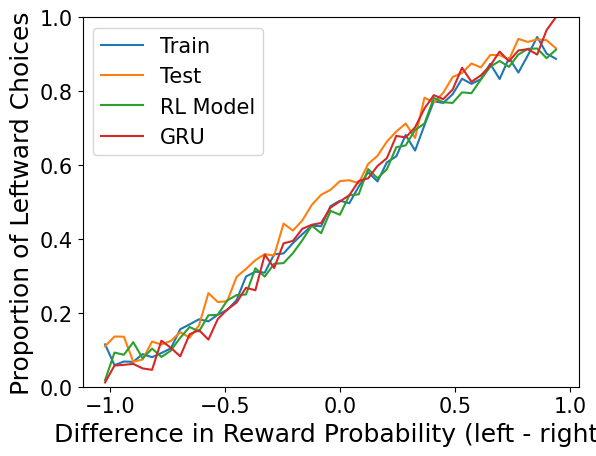

In [ ]:
#@title Plot behavior diagnostics
bandits.show_valuemetric(experiment_list_train, label='Train')
bandits.show_total_reward_rate(experiment_list_train)

bandits.show_valuemetric(experiment_list_test, label='Test')
bandits.show_total_reward_rate(experiment_list_test)

bandits.show_valuemetric(experiment_list_rl, label='RL Model')
bandits.show_total_reward_rate(experiment_list_rl)

bandits.show_valuemetric(experiment_list_gru, label='GRU')
bandits.show_total_reward_rate(experiment_list_gru)

plt.legend()


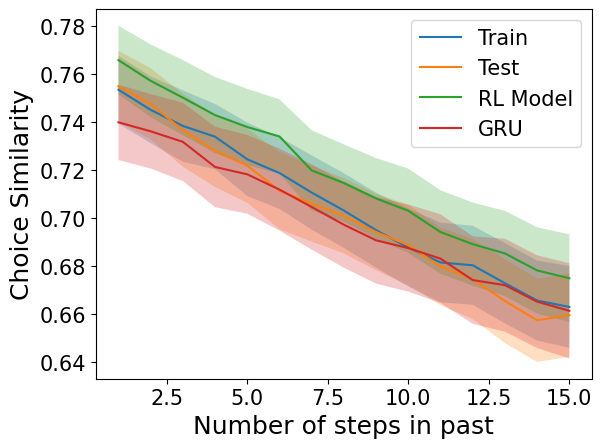

In [ ]:
plotting.plot_action_similarity_to_history(
    experiment_list_train,
    experiment_list_test,
    experiment_list_rl,
    experiment_list_gru,
    n_steps_back=16,
    labels=['Train', 'Test', 'RL Model', 'GRU'])



**Questions**
* How does the log likelihood compare for the RNN compare to the RL model we fit?

Now that we have thought about model fit (predictive power), let's think about interpretability.
* Before you run the next cell, think about what it would mean for the model to be interpretable. In other words, how could we use the model to understand the cognitive better than agents were using in the dataset? (Hint: Remember what we did in the case of the Q-learning model: We could plot the values over time, and get a good sense of why it chose the actions it chose at which trials.)
* Now, execute the next cell. What does the plot show? What does this mean in terms of interpretability?

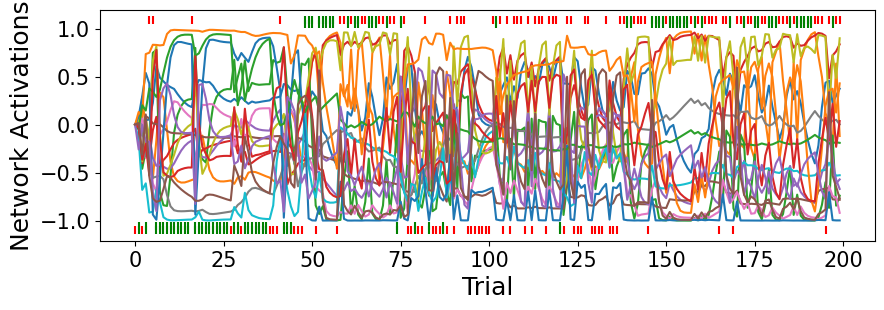

In [ ]:
#@title Interpreting the trained RNN
# Run the agent on a session
xs, ys = next(dataset_test)
network_outputs, network_states = rnn_utils.eval_model(make_gru, gru_params, xs)

# Plot session
network_states = np.array(network_states)
sess_i = 0

trial_end = rnn_utils.find_session_end(xs[:, sess_i, 0])
choices = xs[:trial_end, sess_i, 0]
rewards = xs[:trial_end, sess_i, 1]
gru_activations = network_states[:trial_end, 0, sess_i, :]
bandits.plot_session(
    choices=choices,
    rewards=rewards,
    timeseries=gru_activations,
    timeseries_name='Network Activations')

**Questions:**
* To what extent are these activations "interpretable"? Is it even possible to tell from this figure?
* What else might you do to try and interpret this further? (Feel free to create new code blocks and try out your ideas!)

**Questions:**
* How well do the different models we've looked at so far?
* How do they differ in terms of predictability and interpretability?

# Section 4: Disentangled RNNs

In this section, we will explore using "disentangled RNNs" ([Miller et al 2023](https://www.biorxiv.org/content/10.1101/2023.06.23.546250v1)) to learn a predictive model that is constrained to yield interpretable latent variables. The model fitting will proceed in the same fashion as in parts 1 + 2; however, now the model has additional structure that will encourage it to learn more interpretable models.

Training this model can take several minutes, even if you are connected to a GPU kernel. If you are impatient to move on to Hybrid-RNNs, you can lower the number of steps for training (`n_steps`), but keep in mind this model's performance (and interpretability) will suffer.

## Set up and train a disRNN

**Select disRNN size**

In [ ]:
#Select DisRNN Parameters
#@markdown Number of latent units in the model.
latent_size = 4  #@param

#@markdown Number of hidden units in each of the two layers of the update MLP.
update_mlp_shape = (3,3,)  #@param

#@markdown Number of hidden units in each of the two layers of the choice MLP.
choice_mlp_shape = (2,)

def make_disrnn():
  model = disrnn.HkDisRNN(latent_size = latent_size,
                          update_mlp_shape = update_mlp_shape,
                          choice_mlp_shape = choice_mlp_shape,
                          target_size=2)
  return model

def make_disrnn_eval():
  model = disrnn.HkDisRNN(latent_size = latent_size,
                          update_mlp_shape = update_mlp_shape,
                          choice_mlp_shape = choice_mlp_shape,
                          target_size=2,
                          eval_mode=True)
  return model


optimizer = optax.adam(learning_rate=5e-3)

**Fit the DisRNN**

Fitting the disRNN can be rather time consuming if you are running on a CPU. If you are not connected to a GPU or TPU backend, you may want to set n_steps to a very low value, and come back to this part later.

Begin training with no information penalty. This allows the network to find a solution that fits the dataset well, though it may not be particularly simple


In [ ]:
#Fit disRNN without penalty
#@markdown You can experiment with different values, but colab has been tested with 1000.
n_steps = 1000 #@param
information_penalty = 0

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = dataset_train,
    optimizer = optimizer,
    loss_fun = 'penalized_categorical',
    penalty_scale=information_penalty,
    n_steps=n_steps,
    do_plot=False,
    truncate_seq_length=200,
)

Step 1000 of 1000; Loss: 7.8341e+03. (Time: 33.4s)

Introduce the information penalty and continue training. This encourages the network to find a simpler solution that is still consistent with the dataset

Step 5000 of 5000; Loss: 8.2784e+03. (Time: 149.0s)

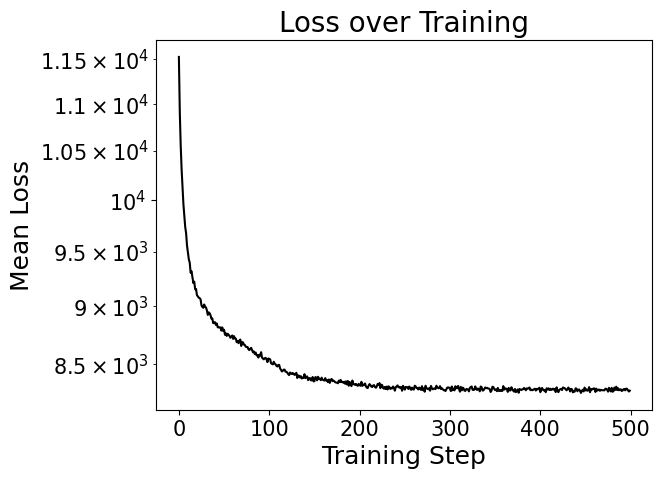

In [ ]:
#Introduce penalty and continue training
#@markdown You can experiment with different values, but colab has been tested with 5000.
n_steps = 5000  #@param
information_penalty = 3e-3  #@param

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = dataset_train,
    optimizer = optimizer,
    loss_fun = 'penalized_categorical',
    params=disrnn_params,
    opt_state=opt_state,
    penalty_scale=information_penalty,
    n_steps=n_steps,
    truncate_seq_length=200,
)

## Interpreting the trained disRNN

Here we will visualize the model update terms and the masking on each latent variable and input. We will also plot the activities of latent units in the model to see if they reveal anything about the learning mechanisms.

[<Figure size 1600x550 with 4 Axes>, <Figure size 1600x550 with 4 Axes>]

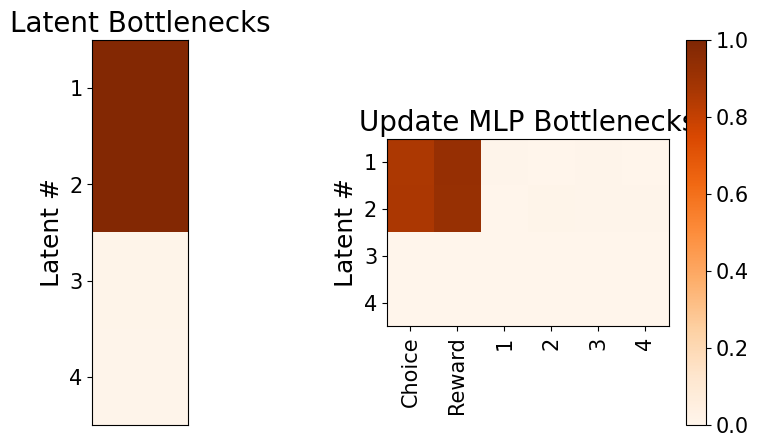

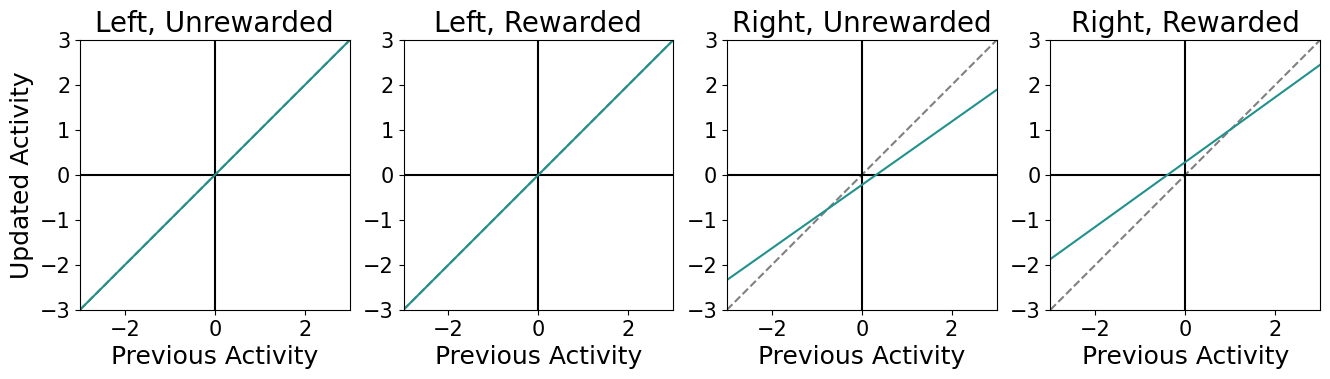

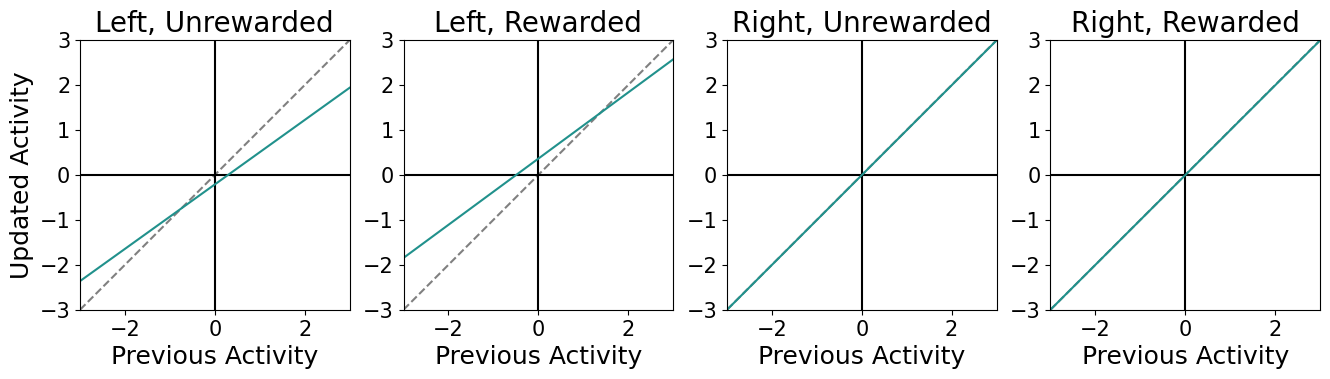

In [ ]:
#@title Visualize bottleneck latents + learned update.
disrnn.plot_bottlenecks(disrnn_params)
disrnn.plot_update_rules(disrnn_params, make_disrnn_eval)

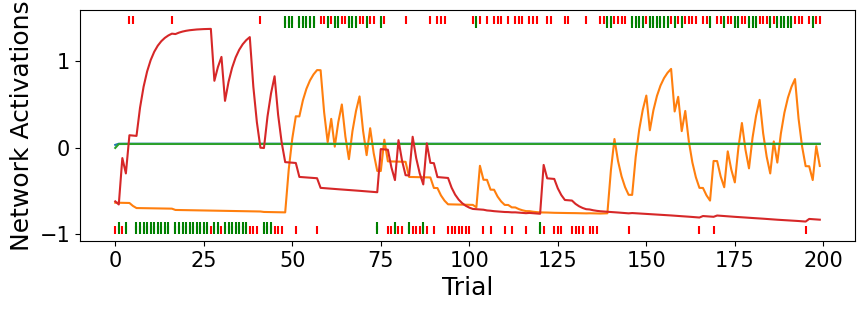

In [ ]:
#@title Plot example session: latents + choices.
xs, ys = next(dataset_test)
sess_i = 0
trial_end = rnn_utils.find_session_end(xs[:, sess_i, 0])
network_outputs, network_states = rnn_utils.eval_model(
    make_disrnn_eval, disrnn_params, xs[:trial_end, sess_i:sess_i+1])
network_states = np.array(network_states)
choices = xs[:trial_end, sess_i, 0]
rewards = xs[:trial_end, sess_i, 1]
disrnn_activations = network_states[:trial_end, sess_i, :]
bandits.plot_session(choices=choices,
                     rewards=rewards,
                     timeseries=disrnn_activations,
                     timeseries_name='Network Activations')

## Quantitative quality-of-fit.
Normalized likelihoods of held-out data

In [ ]:
print('Normalized Likelihoods for Disentangled RNN')
print('Training Dataset')
training_likelihood = compute_log_likelihood(
    dataset_train, make_disrnn_eval, disrnn_params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(
    dataset_test, make_disrnn_eval, disrnn_params)

Normalized Likelihoods for Disentangled RNN
Training Dataset
Normalized Likelihood: 67.7%
Held-Out Dataset
Normalized Likelihood: 67.8%


## Qualitative quality-of-fit.
Generate synthetic datasets from the trained disRNN, compute behavior diagnostics and compare to our original dataset.

In [ ]:
# Synthesize a dataset using the fit network
disrnn_agent = bandits.AgentNetwork(make_disrnn_eval, disrnn_params)

_, experiment_list_disrnn = bandits.create_dataset(
    disrnn_agent, environment, n_trials_per_session, n_sessions)

Total Reward Rate is: 60.290%
Total Reward Rate is: 58.400%
Total Reward Rate is: 60.335%
Total Reward Rate is: 58.435%
Total Reward Rate is: 59.185%


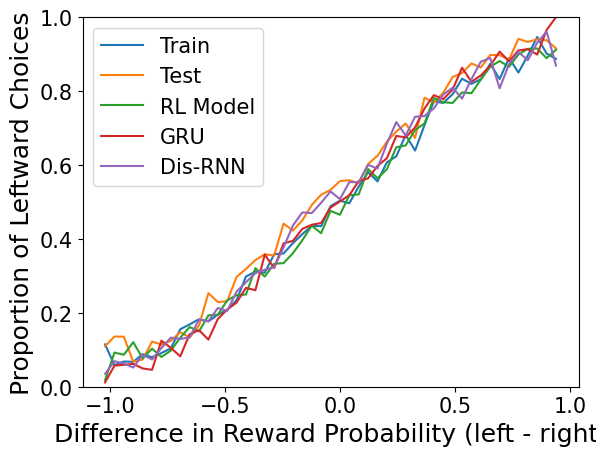

In [ ]:
#Plot value curve
bandits.show_valuemetric(experiment_list_train, label='Train')
bandits.show_total_reward_rate(experiment_list_train)

bandits.show_valuemetric(experiment_list_test, label='Test')
bandits.show_total_reward_rate(experiment_list_test)

bandits.show_valuemetric(experiment_list_rl, label='RL Model')
bandits.show_total_reward_rate(experiment_list_rl)

bandits.show_valuemetric(experiment_list_gru, label='GRU')
bandits.show_total_reward_rate(experiment_list_gru)

bandits.show_valuemetric(experiment_list_disrnn, label='Dis-RNN')
bandits.show_total_reward_rate(experiment_list_disrnn)

plt.legend()



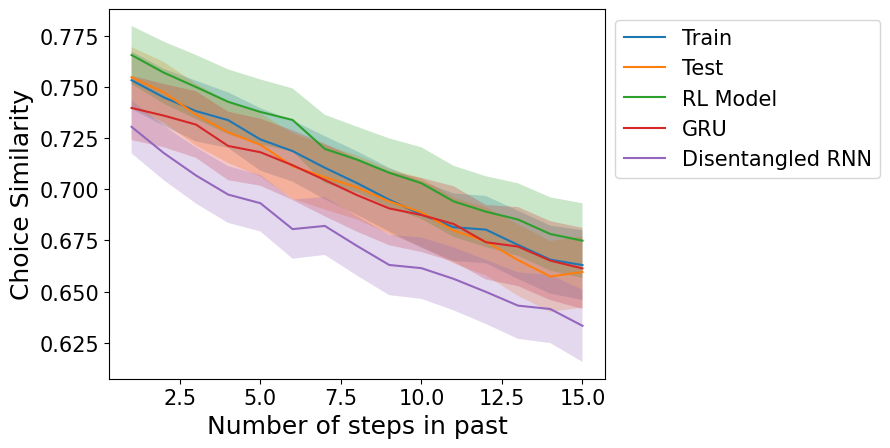

In [ ]:

# Plot action correlations
plotting.plot_action_similarity_to_history(
    experiment_list_train,
    experiment_list_test,
    experiment_list_rl,
    experiment_list_gru,
    experiment_list_disrnn,
    n_steps_back=16,
    labels=['Train', 'Test', 'RL Model', 'GRU', 'Disentangled RNN'])

# Section 5: Hybrid RNNs

In this section, we will explore a different approach to building interpretable models with RNNs: the hybrid-RNN approach from [Eckstein et al 2023](https://www.biorxiv.org/content/10.1101/2023.05.17.541226v1.abstract). The central idea is to replace components of RL models one-by-one with Neural Networks, thus using data to fit certain terms with potentially complex functions.

## Set up and train a HybRNN
<a name="define-hybrnn"></a>

In [ ]:
#@title Define a HybRNN Structure.

#@markdown Does the hybRNN contain a reward-learning module? (if not, it will be blind to rewards)
reward_learning = 'True'  #@param ['True', 'False']

#@markdown Does reward module do incremental learning? (i.e. does new Q-value depend on previous Q-value?)
use_previous_values = 'True'  #@param ['True', 'False']

#@markdown Are values of unchosen actions gradually "forgotten"?
fit_forget = "True"  #@param ['True', 'False']

#@markdown Does the hybRNN contain an action-learning module?
action_learning = 'False'  #@param ['True', 'False']

#@markdown Do reward and action modules use flexible memory? (i.e. does new Q-value depend on previous hidden state?)
use_hidden_state = 'False'  #@param ['True', 'False']

#@markdown How many hidden units are in each module?
n_hidden = 8 #@param[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

#@markdown Maximum number of steps to train for
n_steps_max = 1000 #@param


if action_learning:
  habit_weight = 1.
else:
  habit_weight = 0.

if reward_learning:
  value_weight = 1.
else:
  value_weight = 0.

rnn_rl_params = {
    's': use_hidden_state == 'True',
    'o': use_previous_values == 'True',
    'fit_forget': fit_forget == 'True',
    'forget': 0.,
    'w_h': habit_weight,
    'w_v': value_weight}
network_params = {'n_actions': 2, 'hidden_size': n_hidden}

def make_hybrnn():
  model = hybrnn.BiRNN(rl_params=rnn_rl_params, network_params=network_params)
  return model

optimizer = optax.adam(learning_rate=5e-2)

In [ ]:
#@title Fit the hybrid RNN
hybrnn_params, _ = rnn_utils.fit_model(
    model_fun=make_hybrnn,
    dataset=dataset_train,
    optimizer=optimizer,
    loss_fun='categorical',
    convergence_thresh=1e-3,
    n_steps_max=n_steps_max,
)


Step 500 of 500; Loss: 7.7895e+03. (Time: 3.7s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 3e-05s.
Step 500 of 500; Loss: 7.7825e+03. (Time: 3.7s)
Model Converged! Time elapsed = 4e-05s.


## Quantitative Quality-of-Fit

In [ ]:
#Quantitative quality-of-fit
print('Normalized Likelihoods for Hybrid RNN')
print('Training Dataset')
training_likelihood = compute_log_likelihood(dataset_train, make_hybrnn, hybrnn_params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_test, make_hybrnn, hybrnn_params)

Normalized Likelihoods for Hybrid RNN
Training Dataset
Normalized Likelihood: 67.8%
Held-Out Dataset
Normalized Likelihood: 67.8%


## Qualitative quality-of-fit
Generate a synthetic dataset from the trained HybRNN. Compare it to the original dataset using or diagnostic plots

In [ ]:
# Generate synthetic dataset
hybrnn_agent = bandits.AgentNetwork(make_hybrnn, hybrnn_params, )
_, experiment_list_hybrnn = bandits.create_dataset(
    hybrnn_agent, environment, n_trials_per_session, n_sessions)

Total Reward Rate is: 60.290%
Total Reward Rate is: 58.400%
Total Reward Rate is: 60.335%
Total Reward Rate is: 58.435%
Total Reward Rate is: 59.185%
Total Reward Rate is: 59.415%


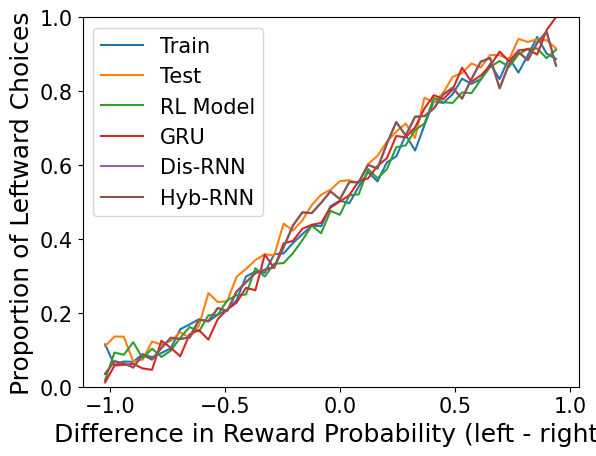

In [ ]:
# Plot value curves.

bandits.show_valuemetric(experiment_list_train, label='Train')
bandits.show_total_reward_rate(experiment_list_train)

bandits.show_valuemetric(experiment_list_test, label='Test')
bandits.show_total_reward_rate(experiment_list_test)

bandits.show_valuemetric(experiment_list_rl, label='RL Model')
bandits.show_total_reward_rate(experiment_list_rl)

bandits.show_valuemetric(experiment_list_gru, label='GRU')
bandits.show_total_reward_rate(experiment_list_gru)

bandits.show_valuemetric(experiment_list_disrnn, label='Dis-RNN')
bandits.show_total_reward_rate(experiment_list_disrnn)

bandits.show_valuemetric(experiment_list_disrnn, label='Hyb-RNN')
bandits.show_total_reward_rate(experiment_list_hybrnn)

plt.legend()

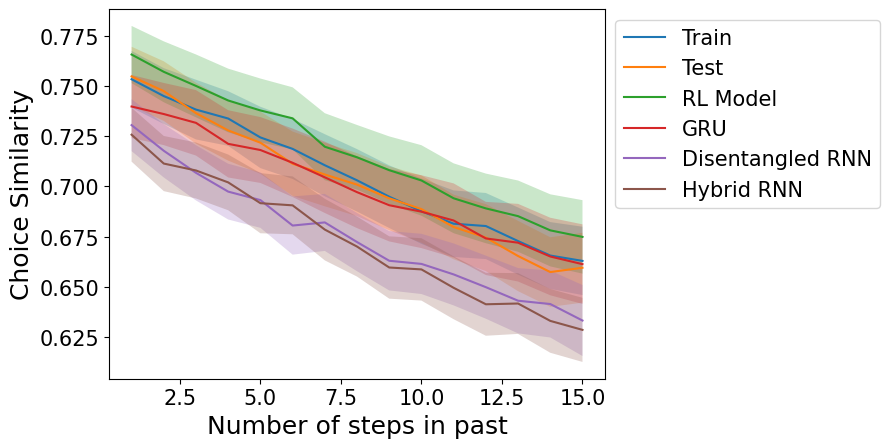

In [ ]:
# Plot choice autocorrelations
plotting.plot_action_similarity_to_history(
    experiment_list_train,
    experiment_list_test,
    experiment_list_rl,
    experiment_list_gru,
    experiment_list_disrnn,
    experiment_list_hybrnn,
    n_steps_back=16,
    labels=['Train', 'Test', 'RL Model', 'GRU', 'Disentangled RNN', 'Hybrid RNN'],
    bbox_to_anchor=(1, 1))


## Interpreting the trained HybRNN
The reward and action modules each have separate decision variables, which drive future choice, and recurrent activities, which affect update of the decision variables. The code below will plot whichever of these exist in your hybRNN (which will depend on the structure you selected above).

In [ ]:
# Record network variables
xs, ys = next(dataset_test)
n_trials_per_session, n_sessions, _ = np.shape(xs)
hybrnn_outputs, hybrnn_states = rnn_utils.eval_model(make_hybrnn, hybrnn_params, xs)

h_state = np.zeros((n_trials_per_session, n_sessions, network_params['hidden_size']))
v_state = np.zeros((n_trials_per_session, n_sessions, network_params['hidden_size']))
h = np.zeros((n_trials_per_session, n_sessions, network_params['n_actions']))
v = np.zeros((n_trials_per_session, n_sessions, network_params['n_actions']))


for t in range(n_trials_per_session):
  for s in range(len(hybrnn_states)):

    if action_learning == 'True':
      h[t] = hybrnn_states[t][2]
      if use_hidden_state  == 'True':
        h_state[t] = hybrnn_states[t][0]

    if reward_learning  == 'True':
      v[t] = hybrnn_states[t][3]
      if use_hidden_state == 'True':
        v_state[t] = hybrnn_states[t][1]



Text(0.5, 1.0, 'Action Module Recurrent State')

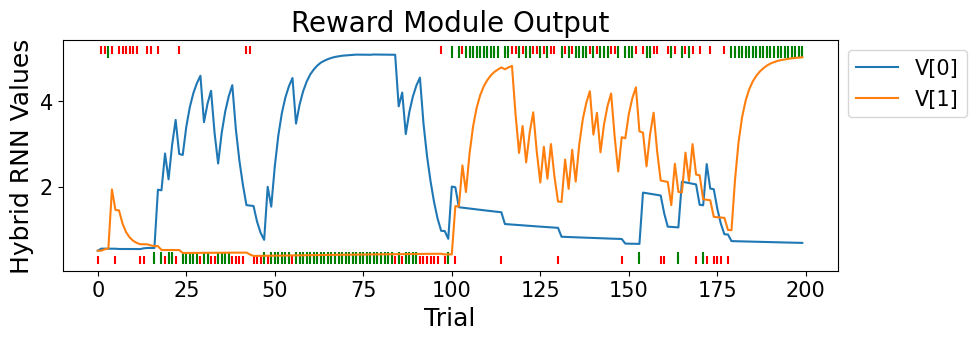

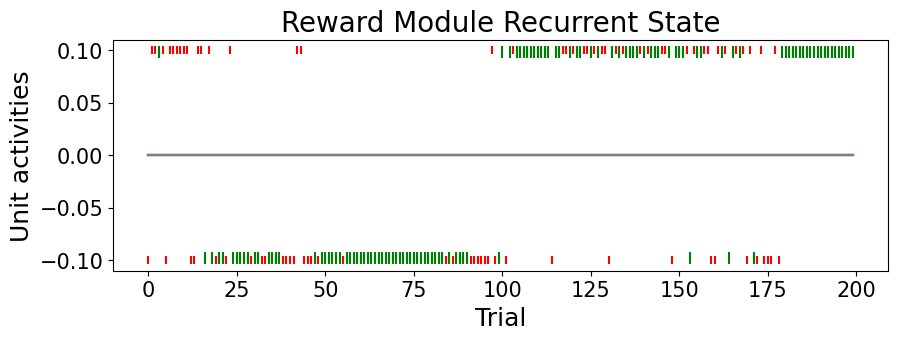

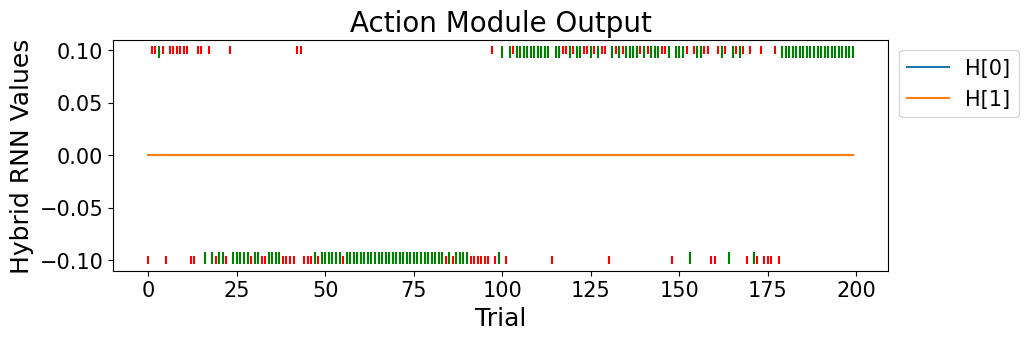

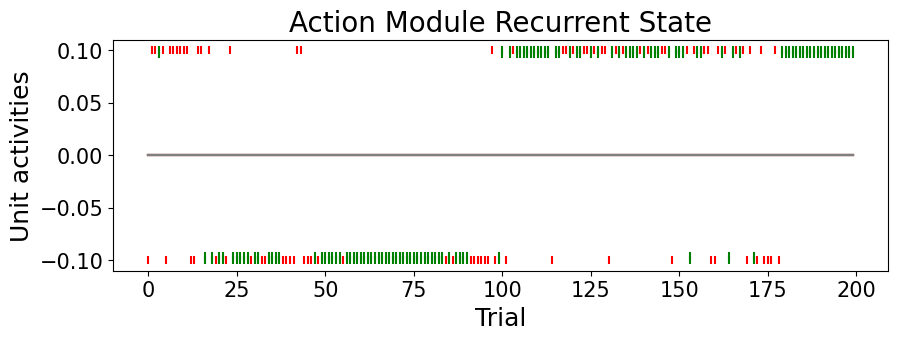

In [ ]:
# Plot example session:
sess_i = 1
choices = xs[:, sess_i, 0]
rewards = xs[:, sess_i, 1]

hybrnn_values = v[:, sess_i, :]
hybrnn_v_state = v_state[:, sess_i, :]

hybrnn_hs = h[:, sess_i, :]
hybrnn_h_state = h_state[:, sess_i, :]

bandits.plot_session(choices=choices,
                     rewards=rewards,
                     timeseries=hybrnn_values,
                     timeseries_name='Hybrid RNN Values', labels=['V[0]', 'V[1]'])
plt.title('Reward Module Output')

bandits.plot_session(choices=choices,
                     rewards=rewards,
                     timeseries=hybrnn_v_state,
                     timeseries_name='Unit activities')
plt.title('Reward Module Recurrent State')

bandits.plot_session(choices=choices,
                     rewards=rewards,
                     timeseries=hybrnn_hs,
                     timeseries_name='Hybrid RNN Values', labels=['H[0]', 'H[1]'])
plt.title('Action Module Output')

bandits.plot_session(choices=choices,
                     rewards=rewards,
                     timeseries=hybrnn_h_state,
                     timeseries_name='Unit activities')
plt.title('Action Module Recurrent State')

**Questions:**

* How do these relate to the Q-values plotted for the classic model, or the activations plotted for the GRU?.
* How might we interpret them further?

## Compare different Hybrid RNN Structures
Go back to where we defined the [HybRNN Structure](#define-hybrnn).

Select a different structure and run Section 5 again. How do the results differ?

# Part 6: Synthetic mystery dataset

Congratulations, you have learned about a classic Q-learning agent, about model fitting, about neural networks, and about two new classes of interpretable models!

Now let's try putting this knowledge to work discvering the structure of an *unknown* agent.

Return to [Select a Dataset](#select-dataset) and select `Synthetic Data: Mystery Agent`. Repeat Parts 2, 3, and 4.

What computational mechanisms do you think are present in the mystery agent?

# Part 7: Laboratory datasets

Ready to move beyond re-discovering structure in synthetic datasets, and try discovering something new using real data from the lab?

Go back to [Select a Dataset](#select-dataset) and choose one of the rat datasets.

How do the models differ? What computational mechanisms do you think are present in the mind of the rat?

Note: some parts of the visualizations will not work in the same way, since experiment_list_train and experiment_list_test are generated synthetically. What other metrics might you be interested in plotting?